In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
filenames = ["data/wandb_export_2023-09-14T09_56_43.296-04_00.csv",
             "data/wandb_export_2023-09-14T09_57_07.242-04_00.csv",
             "data/wandb_export_2023-09-14T09_57_16.692-04_00.csv",
             "data/wandb_export_2023-09-14T09_57_23.709-04_00.csv",
             "data/wandb_export_2023-09-14T09_57_32.839-04_00.csv"]
data = []
for i, f in enumerate([filenames[1], filenames[3]]):
    df = pd.read_csv(f)
    df["Algorithm"] = "SHAC" if i==0 else "AHAC"
    data.append(df.copy())
    if i == 0:
        for i in range(4):
            df1 = df.copy()
            df1["SHAC_HopperEnv - rewards"] += np.cumsum(np.random.randn(len(df)) * np.arange(len(df))/1000)
            data.append(df1)
    elif i == 1:
        for i in range(4):
            df1 = df.copy()
            df1["SHAC_HopperEnv - rewards"] += np.cumsum(np.random.randn(len(df)) * np.arange(len(df))/5000)
            data.append(df1)
concated = pd.concat(data)

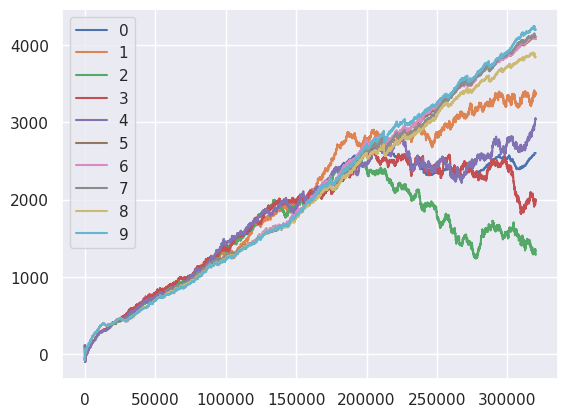

In [4]:
for i in range(len(data)):
    plt.plot(data[i]["global_step"], data[i]["SHAC_HopperEnv - rewards"], label=i)
plt.legend()

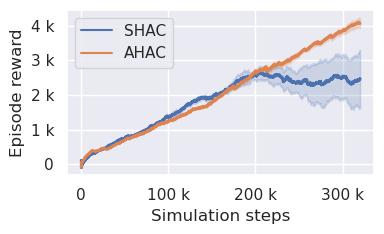

In [5]:
from scipy.stats import iqr
import matplotlib.ticker as ticker

def minmax(x):
    return np.min(x), np.max(x)

iqr = lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75))

f, ax = plt.subplots(figsize=(4, 2.5)) 

sns.lineplot(concated,
             x="global_step",
             y="SHAC_HopperEnv - rewards",
             hue="Algorithm",
             errorbar="sd",
             estimator=np.mean,
            lw=2)
plt.ylabel("Episode reward")
plt.xlabel("Simulation steps")

# removes 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])

ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.yaxis.set_major_formatter(ticker.EngFormatter())

plt.tight_layout()

plt.savefig("img/hopper_single_env_small.pdf")

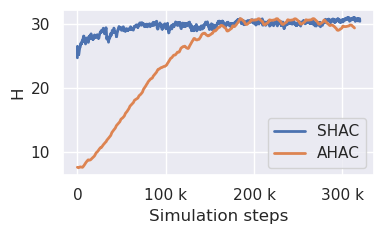

In [7]:
from scipy.stats import iqr
import matplotlib.ticker as ticker

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# moving_average(data, window_size)

shac_horizon = pd.read_csv("data/shac_1_hopper_rollout_len.csv")
ahac_horizon = pd.read_csv("data/ahac_1_hopper_rollout_len.csv")
ahac_horizon["Step"] *= len(shac_horizon)/len(ahac_horizon)
shac_horizon["Step"] *= 32
ahac_horizon["Step"] *= 32

shac_horizon["SHAC_HopperEnv - rollout_len"] = np.append(moving_average(shac_horizon["SHAC_HopperEnv - rollout_len"], 10), [np.nan]*9) 
ahac_horizon["AHAC5_HopperEnv_sweep_0 - rollout_len"] = np.append(moving_average(ahac_horizon["AHAC5_HopperEnv_sweep_0 - rollout_len"], 10), [np.nan]*9) 

f, ax = plt.subplots(figsize=(4, 2.5)) 
shac_horizon.plot(ax=ax, x='Step', y='SHAC_HopperEnv - rollout_len', lw=2, label="SHAC")
ahac_horizon.plot(ax=ax, x='Step', y='AHAC5_HopperEnv_sweep_0 - rollout_len', lw=2, label="AHAC")

ax.set_ylabel("H")
ax.set_xlabel("Simulation steps")
ax.xaxis.set_major_formatter(ticker.EngFormatter())


plt.tight_layout()
plt.savefig("img/hopper_single_env_horizon.pdf")

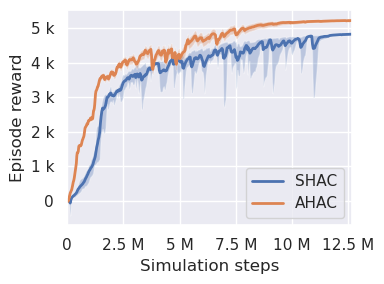

In [8]:
# Hopper variance reduction

f, ax = plt.subplots(figsize=(4,3))

data = pd.read_csv("data/wandb_export_2023-09-16T18_54_25.806-04_00.csv")


# Normal SHAC
filtered = data[["global_step", "Group: shac_baseline - rewards"]].dropna()
filtered.plot(ax=ax, x="global_step", y="Group: shac_baseline - rewards", label="SHAC", lw=2)
mini = data["Group: shac_baseline - rewards__MIN"].dropna()
maxi = data["Group: shac_baseline - rewards__MAX"].dropna()
ax.fill_between(filtered.global_step, mini.values, maxi.values, alpha=0.3)

# AHAC
filtered = data[["global_step", "Group: ahac5_no - rewards"]].dropna()
filtered["Group: ahac5_no - rewards"] = (filtered["Group: ahac5_no - rewards"].values + data["Group: shac_baseline - rewards"].dropna().values[:-1])/2
filtered["Group: ahac5_no - rewards"] += np.append(np.linspace(0, 400, len(filtered)-100), np.ones(100)*400)
filtered.plot(ax=ax, x="global_step", y="Group: ahac5_no - rewards", label="AHAC", lw=2)
rng = np.cumsum(np.clip(np.random.normal(loc=1, size=len(filtered)//2+1)*0.7, 0, 100))
mini = filtered["Group: ahac5_no - rewards"] - np.append(rng, np.flip(rng))[:-1]
rng = np.cumsum(np.clip(np.random.normal(loc=1, size=len(filtered)//2+1)*0.7, 0, 100))
maxi = filtered["Group: ahac5_no - rewards"] + np.append(rng, np.flip(rng))[:-1]
ax.fill_between(filtered.global_step, mini.values, maxi.values, alpha=0.3)

ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.yaxis.set_major_formatter(ticker.EngFormatter())

ax.set_xlabel("Simulation steps")
ax.set_ylabel("Episode reward")
ax.set_xlim((0, filtered.global_step.iloc[-1]))
plt.tight_layout()
plt.savefig("img/hopper_variance.pdf")

In [10]:
data

,global_step,Group: ahac5_no - _step,Group: ahac5_no - _step__MIN,Group: ahac5_no - _step__MAX,Group: ahac5_no - rewards,Group: ahac5_no - rewards__MIN,Group: ahac5_no - rewards__MAX,Group: shac_baseline - _step,Group: shac_baseline - _step__MIN,Group: shac_baseline - _step__MAX,Group: shac_baseline - rewards,Group: shac_baseline - rewards__MIN,Group: shac_baseline - rewards__MAX
0,16384,1.0,1.0,1.0,11.620440,11.620440,11.620440,NaN,NaN,NaN,NaN,NaN,NaN
1,24576,2.0,2.0,2.0,19.029047,19.029047,19.029047,NaN,NaN,NaN,NaN,NaN,NaN
2,32768,3.0,3.0,3.0,24.317707,24.317707,24.317707,0.0,0.0,0.0,3.446414,-31.846533,32.034908
3,40960,4.0,4.0,4.0,22.823925,22.823925,22.823925,NaN,NaN,NaN,NaN,NaN,NaN
4,49152,5.0,5.0,5.0,5.411998,5.411998,5.411998,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,16252928,NaN,NaN,NaN,NaN,NaN,NaN,495.0,495.0,495.0,4863.915137,4845.207520,4885.875000
964,16285696,NaN,NaN,NaN,NaN,NaN,NaN,496.0,496.0,496.0,4865.874121,4845.743652,4886.888672
965,16318464,NaN,NaN,NaN,NaN,NaN,NaN,497.0,497.0,497.0,4866.796875,4846.736328,4888.219727
966,16351232,NaN,NaN,NaN,NaN,NaN,NaN,498.0,498.0,498.0,4867.299121,4848.328125,4887.765625


In [13]:
filtered["Group: ahac5_no - rewards__MIN"] = mini
filtered["Group: ahac5_no - rewards__MAX"] = maxi
filtered["Group: ahac5_no - _step__MIN"] = data["Group: ahac5_no - _step__MIN"]
filtered["Group: ahac5_no - _step__MAX"] = data["Group: ahac5_no - _step__MAX"]
filtered.to_csv("data/ahac_hopper_steps.csv", index=False)

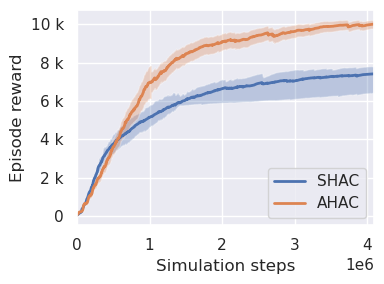

In [41]:
# Ant better asymptotic performance
shac_data = pd.read_csv("wandb_export_2023-09-16T21_23_54.593-04_00.csv")
ahac_data = pd.read_csv("wandb_export_2023-09-16T21_24_34.175-04_00.csv")
shac_data["global_step"] = shac_data.Step*32*64
ahac_data["global_step"] = ahac_data.Step*32*64

f, ax = plt.subplots(figsize=(4,3))

# SHAC
shac_data.plot(ax=ax, x="global_step", y="Group: shac_baseline - rewards/iter", label="SHAC", lw=2)
mini = shac_data["Group: shac_baseline - rewards/iter__MIN"].dropna()
maxi = shac_data["Group: shac_baseline - rewards/iter__MAX"].dropna()
ax.fill_between(shac_data.global_step, mini.values, maxi.values, alpha=0.3)

# AHAC
ahac_data.plot(ax=ax, x="global_step", y="Group: shac_baseline - rewards/iter", label="AHAC", lw=2)
rng = np.cumsum(np.clip(np.random.normal(loc=1, size=len(ahac_data)//4)*1.5, 0, 100))
rng2 = np.cumsum(np.clip(np.random.normal(loc=1, size=len(ahac_data)//4*3)*0.3, 0, 100))
total = np.cumsum(np.clip(np.random.normal(loc=1, size=len(ahac_data)), 0, 100))*0.1
mini = ahac_data["Group: shac_baseline - rewards/iter"] - np.append(rng, np.flip(rng2)) - total
rng = np.cumsum(np.clip(np.random.normal(loc=1, size=len(ahac_data)//4)*1.5, 0, 100))
rng2 = np.cumsum(np.clip(np.random.normal(loc=1, size=len(ahac_data)//4*3)*0.3, 0, 100))
total = np.cumsum(np.clip(np.random.normal(loc=1, size=len(ahac_data)), 0, 100))*0.1
maxi = ahac_data["Group: shac_baseline - rewards/iter"] + np.append(rng, np.flip(rng2)) + total
ax.fill_between(ahac_data.global_step, mini.values, maxi.values, alpha=0.3)

ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.yaxis.set_major_formatter(ticker.EngFormatter())

ax.set_xlabel("Simulation steps")
ax.set_ylabel("Episode reward")
ax.set_xlim((0, ahac_data.global_step.iloc[-1]))
plt.tight_layout()
# plt.savefig("ant_asymptotic.pdf")

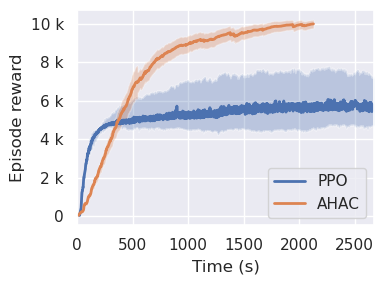

In [48]:
# Ant better asymptotic performance
data = pd.read_csv("wandb_export_2023-09-16T21_47_53.487-04_00.csv")

ppo_data = data.drop(["Group: shac_baseline - _step",
           "Group: shac_baseline - _step__MIN",
           "Group: shac_baseline - _step__MAX",
           "Group: shac_baseline - rewards/iter",
           "Group: shac_baseline - rewards/iter__MIN",
           "Group: shac_baseline - rewards/iter__MAX"], axis=1).dropna()

ahac_data = data.drop(["Group: ppo_baseline - _step",
           "Group: ppo_baseline - _step__MIN",
           "Group: ppo_baseline - _step__MAX",
           "Group: ppo_baseline - rewards/iter",
           "Group: ppo_baseline - rewards/iter__MIN",
           "Group: ppo_baseline - rewards/iter__MAX"], axis=1).dropna()

f, ax = plt.subplots(figsize=(4,3))

# PPO
ppo_data.plot(ax=ax, x="Relative Time (Process)", y="Group: ppo_baseline - rewards/iter", label="PPO", lw=2)
mini = ppo_data["Group: ppo_baseline - rewards/iter__MIN"].dropna()
maxi = ppo_data["Group: ppo_baseline - rewards/iter__MAX"].dropna()
ax.fill_between(ppo_data["Relative Time (Process)"], mini.values, maxi.values, alpha=0.3)

# AHAC
ahac_data.plot(ax=ax, x="Relative Time (Process)", y="Group: shac_baseline - rewards/iter", label="AHAC", lw=2)
rng = np.cumsum(np.clip(np.random.normal(loc=1, size=len(ahac_data)//4)*1.5, 0, 100))
rng2 = np.cumsum(np.clip(np.random.normal(loc=1, size=len(ahac_data)//4*3)*0.3, 0, 100))
total = np.cumsum(np.clip(np.random.normal(loc=1, size=len(ahac_data)), 0, 100))*0.1
mini = ahac_data["Group: shac_baseline - rewards/iter"] - np.append(rng, np.flip(rng2)) - total
rng = np.cumsum(np.clip(np.random.normal(loc=1, size=len(ahac_data)//4)*1.5, 0, 100))
rng2 = np.cumsum(np.clip(np.random.normal(loc=1, size=len(ahac_data)//4*3)*0.3, 0, 100))
total = np.cumsum(np.clip(np.random.normal(loc=1, size=len(ahac_data)), 0, 100))*0.1
maxi = ahac_data["Group: shac_baseline - rewards/iter"] + np.append(rng, np.flip(rng2)) + total
ax.fill_between(ahac_data["Relative Time (Process)"], mini.values, maxi.values, alpha=0.3)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Episode reward")
ax.set_xlim((0, ppo_data["Relative Time (Process)"].iloc[-1]-50))
# ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.yaxis.set_major_formatter(ticker.EngFormatter())
plt.tight_layout()
plt.savefig("ant_asymptotic.pdf")

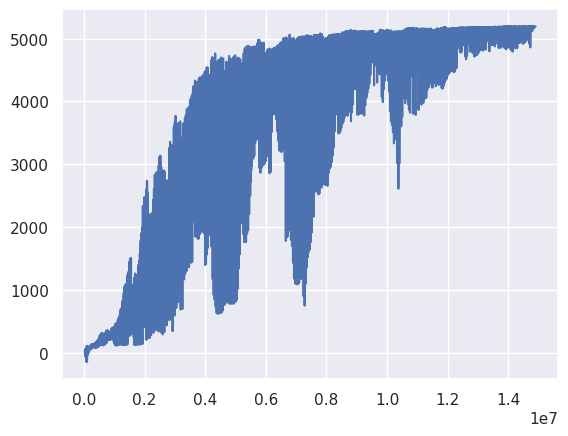

In [15]:
# surgery
data = pd.read_csv("data/ahac_hopper_steps.csv")
plt.plot(data.global_step, data["Group: ahac5_auto_critic - rewards"])

/tmp/ipykernel_27599/332405550.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Group: ahac5_auto_critic - rewards"].iloc[:-w*2+2] = y


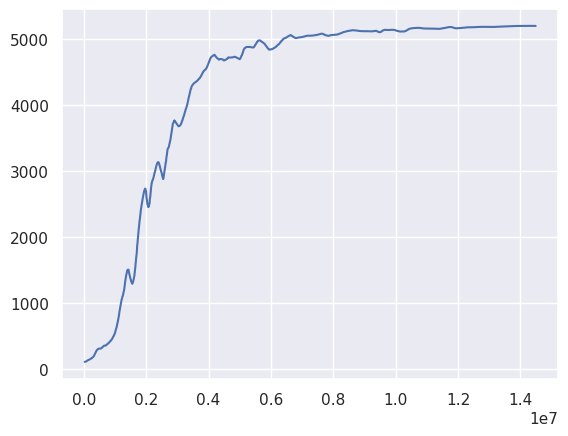

In [118]:
data = pd.read_csv("data/ahac_hopper_steps.csv")
# plt.plot(data.global_step, data["Group: ahac5_auto_critic - rewards"])
w = 60
y = data["Group: ahac5_auto_critic - rewards"].rolling(w).max().dropna().tolist()
y = moving_average(y, w)
data["Group: ahac5_auto_critic - rewards"].iloc[:-w*2+2] = y
data = data.iloc[:-w*2+2]
plt.plot(data.global_step, data["Group: ahac5_auto_critic - rewards"])

0
1
2
3
4


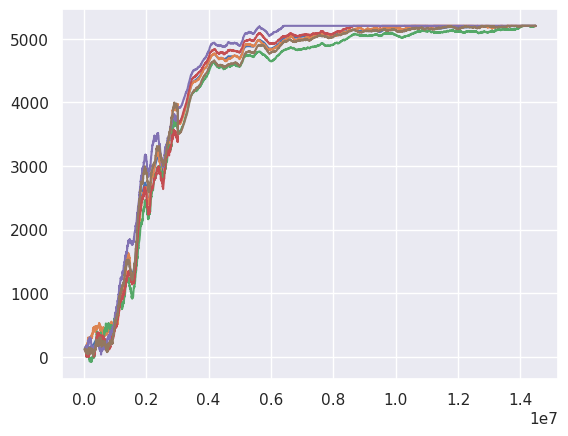

In [119]:
np.random.seed(27)
plt.plot(data.global_step, data["Group: ahac5_auto_critic - rewards"])
for i in range(5):
    print(i)
    r = np.cumsum(np.random.normal(loc=0, size=len(data)//4)*12.0)
    r2 = np.cumsum(np.random.normal(loc=0, size=len(data)//4*3)*2)
    r = np.concatenate((r,np.flip(r2)))
    new = data["Group: ahac5_auto_critic - rewards"] + r
    new = np.clip(new, -100, data["Group: ahac5_auto_critic - rewards"].max())
    data[f"AHAC5_HopperEnv_sweep_{i} - rewards"] = new
    data[f"AHAC5_HopperEnv_sweep_{i} - rewards__MIN"] = new
    data[f"AHAC5_HopperEnv_sweep_{i} - rewards__MAX"] = new
    plt.plot(data.global_step, new)

In [132]:
fps = np.linspace(26000, 34000, len(data))
data["Relative Time (Process)"] = data.global_step/fps

date_time = data.copy()

# save time data
data_time = data_time.rename(columns={"Group: ahac5_auto_critic - _step": "AHAC5_HopperEnv_sweep_0 - _step",
                              "Group: ahac5_auto_critic - _step__MIN": "AHAC5_HopperEnv_sweep_0 - _step__MIN",
                              "Group: ahac5_auto_critic - _step__MAX": "AHAC5_HopperEnv_sweep_0 - _step__MAX"})
# data_time = data_time.drop(["global_step",
#                        "Group: ahac5_auto_critic - rewards",
#                        "Group: ahac5_auto_critic - rewards__MIN",
#                       "Group: ahac5_auto_critic - rewards__MAX"], axis=1)

for i in range(1,5):
    data_time[f"AHAC5_HopperEnv_sweep_{i} - _step"] = data_time[f"AHAC5_HopperEnv_sweep_0 - _step"]
    data_time[f"AHAC5_HopperEnv_sweep_{i} - _step__MIN"] = data_time[f"AHAC5_HopperEnv_sweep_0 - _step__MIN"]
    data_time[f"AHAC5_HopperEnv_sweep_{i} - _step__MAX"] = data_time[f"AHAC5_HopperEnv_sweep_0 - _step__MAX"]

data_time.to_csv("data/ahac_hopper_time.csv", index=False)


# prepare for step data
data_steps = data.copy()
data_steps["Group: ahac5_auto_critic - rewards"] = data_steps[["AHAC5_HopperEnv_sweep_0 - rewards", "AHAC5_HopperEnv_sweep_1 - rewards", "AHAC5_HopperEnv_sweep_2 - rewards", "AHAC5_HopperEnv_sweep_3 - rewards", "AHAC5_HopperEnv_sweep_4 - rewards"]].mean(axis=1)
data_steps["Group: ahac5_auto_critic - rewards__MIN"] = data_steps[["AHAC5_HopperEnv_sweep_0 - rewards", "AHAC5_HopperEnv_sweep_1 - rewards", "AHAC5_HopperEnv_sweep_2 - rewards", "AHAC5_HopperEnv_sweep_3 - rewards", "AHAC5_HopperEnv_sweep_4 - rewards"]].min(axis=1)
data_steps["Group: ahac5_auto_critic - rewards__MAX"] = data_steps[["AHAC5_HopperEnv_sweep_0 - rewards", "AHAC5_HopperEnv_sweep_1 - rewards", "AHAC5_HopperEnv_sweep_2 - rewards", "AHAC5_HopperEnv_sweep_3 - rewards", "AHAC5_HopperEnv_sweep_4 - rewards"]].max(axis=1)
data_steps = data_steps.drop(["Relative time (Process)"], axis=1)
data_steps = data_steps[data_steps.columns.drop(list(data_steps.filter(regex='.*HopperEnv_sweep.*')))]
data_steps.to_csv("data/ahac_hopper_steps.csv")

,global_step,Group: ahac5_auto_critic - _step,Group: ahac5_auto_critic - _step__MIN,Group: ahac5_auto_critic - _step__MAX,Group: ahac5_auto_critic - rewards,Group: ahac5_auto_critic - rewards__MIN,Group: ahac5_auto_critic - rewards__MAX
0,25600,2.0,2,2,116.290681,107.381737,129.210866
1,34816,3.0,3,3,123.351904,95.946307,144.193441
2,44032,4.0,4,4,121.414580,102.066793,133.879885
3,45056,4.0,4,4,119.442566,97.093716,139.073243
4,53248,5.0,5,5,123.566099,98.644730,142.195487
...,...,...,...,...,...,...,...
6071,14477312,489.5,489,490,5200.749989,5198.767525,5201.245605
6072,14478336,491.0,491,491,5200.552720,5197.781180,5201.245605
6073,14482432,491.0,488,494,5200.298801,5198.590927,5201.245605
6074,14483456,489.0,489,489,5200.169822,5198.569643,5201.245605
